In [1]:
#Lossless Compression of Chemical Fingerprints Using Integer Entropy Codes Improves Storage and Retrieval
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2536658/
#Filtered circular fingerprints improve either prediction or runtime performance while retaining interpretability
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5088672/
#Looking at statistics for bits set by Morgan fingerprints
#http://rdkit.blogspot.com/2016/02/morgan-fingerprint-bit-statistics.html

In [2]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from scipy import stats
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [3]:
pubchem_data = pd.read_csv("./Pubchem_92_assays_binary.csv") 


In [4]:
CP_features_list= pubchem_data.columns.to_list()[93:-3]
assay_list= pubchem_data.columns.to_list()[1:93]

In [5]:
def fp_as_DataStructs(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    #arr = np.zeros((1,), np.int)
    #DataStructs.ConvertToNumpyArray(fp, arr)
    return fp

mol_list = [Chem.MolFromSmiles(x) for x in pubchem_data.smiles_r]
pubchem_data['Mol'] = mol_list
pubchem_data['fp'] = [fp_as_DataStructs(x) for x in pubchem_data.Mol]
pubchem_data

,StdInChI,588458,588334,2642,2156,2330,2216,743015,504444,894,...,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0,smiles_r,Mol,fp
0,InChI=1S/C11H14ClN3O4S3/c1-2-3-20-6-11-14-8-4-...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,...,-0.085743,-0.049853,-0.049552,-0.053859,-0.037229,-0.036164,-0.052429,C=CCSCC1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1,<rdkit.Chem.rdchem.Mol object at 0x7fa7d8fc9a60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,InChI=1S/C25H27ClN2O/c26-22-12-7-13-23(18-22)2...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,-0.052889,0.017667,-0.004665,0.006729,0.070510,0.021314,0.030253,OC(CN1CCN(c2cccc(Cl)c2)CC1)C(c1ccccc1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fa7d8fc99a0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,InChI=1S/C18H20O2/c1-18-9-8-14-13-5-3-12(19)10...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,...,0.032980,-0.050662,-0.021212,-0.020383,-0.056293,-0.040187,-0.037869,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,<rdkit.Chem.rdchem.Mol object at 0x7fa7d8fc9940>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,-0.149801,-0.022526,-0.021288,-0.024947,-0.030227,-0.081710,-0.068887,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21,<rdkit.Chem.rdchem.Mol object at 0x7fa7d8fc98e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,InChI=1S/C10H14ClN3/c11-9-2-1-3-10(13-9)14-6-4...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,...,0.022562,-0.157595,-0.117522,-0.119432,0.010668,-0.011003,-0.002506,NC1CCN(c2cccc(Cl)n2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7fa7d8fc9880>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,"InChI=1S/C34H41N5O3S/c1-34(2,3)43(42)39-23-28-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.053411,-0.046787,-0.101272,-0.089872,-0.064416,-0.052383,-0.032502,CC(C)(C)[S@@+]([O-])N1Cc2cc(C(=O)NCCN3CCCCC3)n...,<rdkit.Chem.rdchem.Mol object at 0x7fa7d769f880>,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
10398,"InChI=1S/C34H36N4O3S/c1-34(2,3)42(41)38-22-28-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.046764,-0.123188,-0.146195,-0.156000,0.009448,-0.045693,-0.034523,CC(C)(C)[S@@+]([O-])N1Cc2cc(C(=O)N3CCc4ccccc4C...,<rdkit.Chem.rdchem.Mol object at 0x7fa7d769f8e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10399,"InChI=1S/C33H39N5O3S/c1-33(2,3)42(41)38-22-27-...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.016327,-0.033117,-0.051361,-0.044799,-0.020764,-0.036829,-0.032385,CC(C)(C)[S@+]([O-])N1Cc2cc(C(=O)NCCN3CCCC3)nc(...,<rdkit.Chem.rdchem.Mol object at 0x7fa7d769f940>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
10400,InChI=1S/C27H26ClFN2O6S/c28-17-3-1-16(2-4-17)1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.530553,0.091231,0.031603,0.085972,-0.263527,-0.184970,-0.195966,O=S(=O)(Nc1ccc2c(c1)[C@@H]1C[C@@H](CC(O)=NCc3c...,<rdkit.Chem.rdchem.Mol object at 0x7fa7d769f9a0>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
pubchem_data_compounds= pubchem_data[["smiles_r", "StdInChI"]]
Ser_Mol = pubchem_data_compounds['smiles_r'].apply(Chem.MolFromSmiles)


In [7]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint = Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table ['StdInChI'] = pubchem_data_compounds['StdInChI']

In [8]:
Morganfingerprint_table

,Mfp0,Mfp1,Mfp2,Mfp3,Mfp4,Mfp5,Mfp6,Mfp7,Mfp8,Mfp9,...,Mfp2039,Mfp2040,Mfp2041,Mfp2042,Mfp2043,Mfp2044,Mfp2045,Mfp2046,Mfp2047,StdInChI
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C11H14ClN3O4S3/c1-2-3-20-6-11-14-8-4-...
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C25H27ClN2O/c26-22-12-7-13-23(18-22)2...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C18H20O2/c1-18-9-8-14-13-5-3-12(19)10...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C10H14ClN3/c11-9-2-1-3-10(13-9)14-6-4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"InChI=1S/C34H41N5O3S/c1-34(2,3)43(42)39-23-28-..."
10398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"InChI=1S/C34H36N4O3S/c1-34(2,3)42(41)38-22-28-..."
10399,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"InChI=1S/C33H39N5O3S/c1-33(2,3)42(41)38-22-27-..."
10400,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,InChI=1S/C27H26ClFN2O6S/c28-17-3-1-16(2-4-17)1...


In [9]:
#Morganfingerprint_table.to_csv("Mfp_all_bits_10402.csv", index=False)

In [209]:
from matplotlib import pyplot as plt

In [210]:
Morganfingerprint_table_trial= Morganfingerprint_table.iloc[:2, :-1]
Morganfingerprint_table_trial

,Mfp0,Mfp1,Mfp2,Mfp3,Mfp4,Mfp5,Mfp6,Mfp7,Mfp8,Mfp9,...,Mfp2038,Mfp2039,Mfp2040,Mfp2041,Mfp2042,Mfp2043,Mfp2044,Mfp2045,Mfp2046,Mfp2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
Morganfingerprint_table.iloc[:, :-1].T.sum()

0        47
1        39
2        42
3        38
4        29
         ..
10397    76
10398    70
10399    75
10400    69
10401    65
Length: 10402, dtype: int64

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


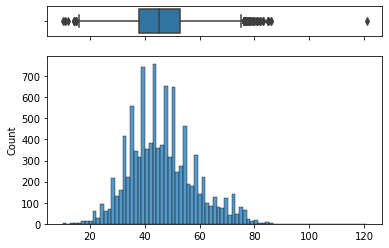

In [212]:
#Number of bits set per molecule
import seaborn as sns

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_box)
sns.histplot(Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [213]:
Morganfingerprint_table.iloc[:, :-1].sum().sort_values(ascending=False)

Mfp1380    10324
Mfp1873    10129
Mfp1750     9475
Mfp807      7962
Mfp1057     7751
           ...  
Mfp498         8
Mfp1748        8
Mfp1890        6
Mfp830         6
Mfp337         5
Length: 2048, dtype: int64

In [214]:
bits = bits= list(range(0, 2048, 1))
bits[-1]

2047

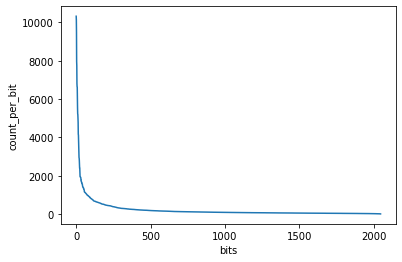

In [215]:
#Number of times each individual bit is set
#Number of bits set per molecule
import seaborn as sns

count_per_bit = Morganfingerprint_table.iloc[:, :-1].sum().sort_values(ascending=False).values
bits = bits= list(range(0, 2048, 1))

#create dataframe using two list days and temperature
bit_counts_df = pd.DataFrame({"count_per_bit":count_per_bit, "bits":bits})
 
# Draw line plot
sns.lineplot(y = "count_per_bit", x = "bits", data=bit_counts_df,)
plt.show() # to show graph



In [216]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

In [226]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)

In [227]:
len(selected_Features)

165

In [228]:
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


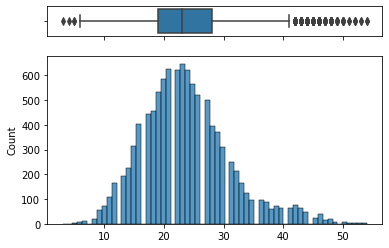

In [229]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(new_Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_box)
sns.histplot(new_Morganfingerprint_table.iloc[:, :-1].T.sum(), ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

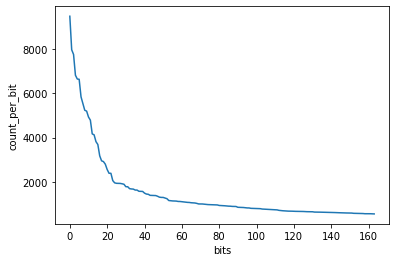

In [230]:
count_per_bit = new_Morganfingerprint_table.iloc[:, :-1].sum().sort_values(ascending=False).values
bits = bits= list(range(0, len(count_per_bit), 1))

#create dataframe using two list days and temperature
bit_counts_df = pd.DataFrame({"count_per_bit":count_per_bit, "bits":bits})
 
# Draw line plot
sns.lineplot(y = "count_per_bit", x = "bits", data=bit_counts_df,)
plt.show() # to show graph



In [231]:
new_Morganfingerprint_table["StdInChI"]= Morganfingerprint_table["StdInChI"]
new_Morganfingerprint_table

/home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Mfp1,Mfp2,Mfp14,Mfp18,Mfp45,Mfp80,Mfp94,Mfp114,Mfp116,Mfp145,...,Mfp1917,Mfp1920,Mfp1928,Mfp1959,Mfp1963,Mfp1970,Mfp1991,Mfp2004,Mfp2009,StdInChI
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C11H14ClN3O4S3/c1-2-3-20-6-11-14-8-4-...
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C25H27ClN2O/c26-22-12-7-13-23(18-22)2...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C18H20O2/c1-18-9-8-14-13-5-3-12(19)10...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C16H13ClN2O/c1-19-14-8-7-12(17)9-13(1...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,InChI=1S/C10H14ClN3/c11-9-2-1-3-10(13-9)14-6-4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,0,1,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,"InChI=1S/C34H41N5O3S/c1-34(2,3)43(42)39-23-28-..."
10398,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,"InChI=1S/C34H36N4O3S/c1-34(2,3)42(41)38-22-28-..."
10399,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,"InChI=1S/C33H39N5O3S/c1-33(2,3)42(41)38-22-27-..."
10400,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,InChI=1S/C27H26ClFN2O6S/c28-17-3-1-16(2-4-17)1...


In [232]:
new_Morganfingerprint_table.to_csv("Mfp_filtered_10402.csv", index=False)